In [24]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("dark")

DATA_ROOT = "../data"

In [25]:
import torch
from torch.utils.data import DataLoader
from utils import SegmentationDataset

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using " + device)

using cpu


In [26]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 8,num_workers =2)

class_dist = {"background":0, "urban_land":0,
              "forest_land":0, "water":0, "agriculture_land":0, "range_land":0, "barren_land":0}
label_mapping = {0: "background", 1: "urban_land",
                 2: "forest_land", 3: "water", 4: "agriculture_land", 5: "range_land", 6: "barren_land"}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

train: 9460 
test: 2027 
val: 2027 

Using the whole train set --> 9460


In [27]:
import albumentations as A


# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([
        A.HueSaturationValue(40,40,30,p=1),
        A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                   contrast_limit = 0.5)], p = 0.5),
    A.OneOf([
        A.RandomRotate90(p=1),
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
    ], p = 0.5)])

In [28]:
!pip install segmentation-models-pytorch

import segmentation_models_pytorch as smp


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
target_names = np.array(["unknown/background", "urban_land/building", "forest_land/woodland", "water", "agriculture_land", "range_land", "barren_land"])

# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass",
                                 classes = 7).to(device)
loss_fn.__name__ = 'JaccardLoss'

# Hyperparameters
batch_size = 4 # TODO adjust this? prev 8 now 4
epochs = 80
epochs = 5
lr = 5e-5

# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = transforms, ratio = 0.8)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.7)

train_dloader = DataLoader(train_set, batch_size = batch_size,
                           shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

train: 9460 
test: 2027 
val: 2027 

Using the 80.00% of the initial train set --> 7568|9460
train: 9460 
test: 2027 
val: 2027 

Using the whole test set --> 2027
train: 9460 
test: 2027 
val: 2027 

Using the 70.00% of the initial val set --> 1418|2027


In [30]:
from utils import training_loop
from utils import class_report
from utils import visualize_preds

In [31]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'


In [32]:
 model = smp.DeepLabV3Plus(encoder_name = "resnet50",
                          encoder_weights = "imagenet",
                          decoder_atrous_rates = (12,18,24),
                          encoder_output_stride =16,
                          classes = 7).to(device)

Training of DeepLabV3+ with Resnet encoder starts!
Using loss as stopping criterion.
Epoch: 1/5     Training Loss: 0.4076     Validation Loss: 0.3478
Validation loss decreased (inf --> 0.347794).  Saving model ...
Epoch: 2/5     Training Loss: 0.3595     Validation Loss: 0.3155
Validation loss decreased (0.347794 --> 0.315484).  Saving model ...
Epoch: 3/5     Training Loss: 0.3394     Validation Loss: 0.3140
Validation loss decreased (0.315484 --> 0.314031).  Saving model ...
Epoch: 4/5     Training Loss: 0.3259     Validation Loss: 0.3137
Validation loss decreased (0.314031 --> 0.313671).  Saving model ...
Epoch: 5/5     Training Loss: 0.3201     Validation Loss: 0.3152
EarlyStopping counter: 1 out of 5


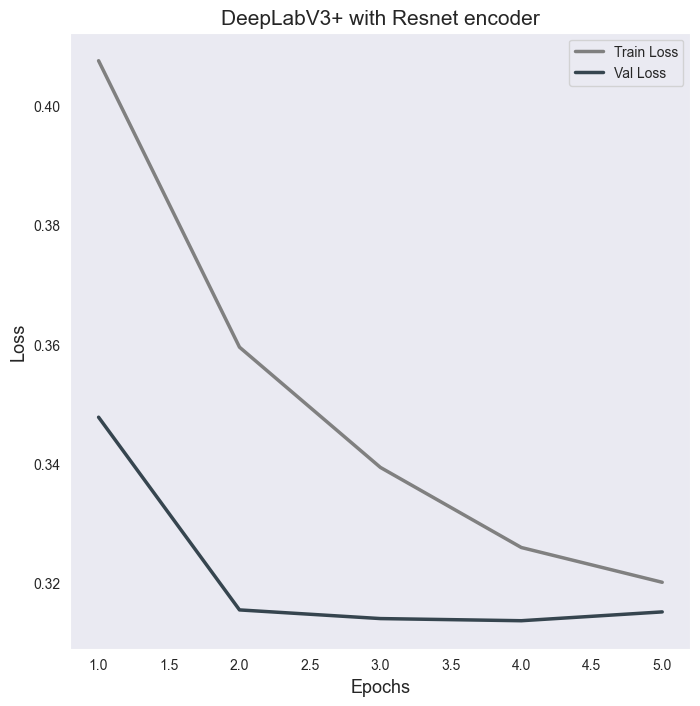


 Training completed in 8.0 h 16.0 m 20.57 s.


In [33]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
              regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
              patience = 5, verbose = True, model_title = "DeepLabV3+ with Resnet encoder", save = True,
              stopping_criterion = "loss")

In [34]:
from utils import segmentation_test_loop
from utils import class_report

# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                                           device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

                  Class  Precision    Recall  F1-Score    Support
0    unknown/background   0.000000  0.000000  0.000000   15251189
1   urban_land/building   0.830724  0.889410  0.859066   58501014
2  forest_land/woodland   0.739113  0.851954  0.791532   66028188
3                 water   0.774245  0.847373  0.809160   17240367
4      agriculture_land   0.941006  0.832638  0.883511  290310202
5            range_land   0.389995  0.505687  0.440369   43745927
6           barren_land   0.555834  0.829899  0.665765   40289001

  Total Accuracy: 0.7907

  Mean IoU:         0.5229

Class Probabilities:
unknown/background  : nan
urban_land/building : 0.986
forest_land/woodland: 0.986
water               : 0.983
agriculture_land    : 0.988
range_land          : 0.964
barren_land         : 0.981


C:\Users\johannes\Documents\uni\maastricht\dlivp-workspace\notebooks\utils.py:529: RuntimeWarning: invalid value encountered in divide
  f1 = np.where((precision + recall) > 0, 2 * (precision * recall) / (precision + recall), 0.0)


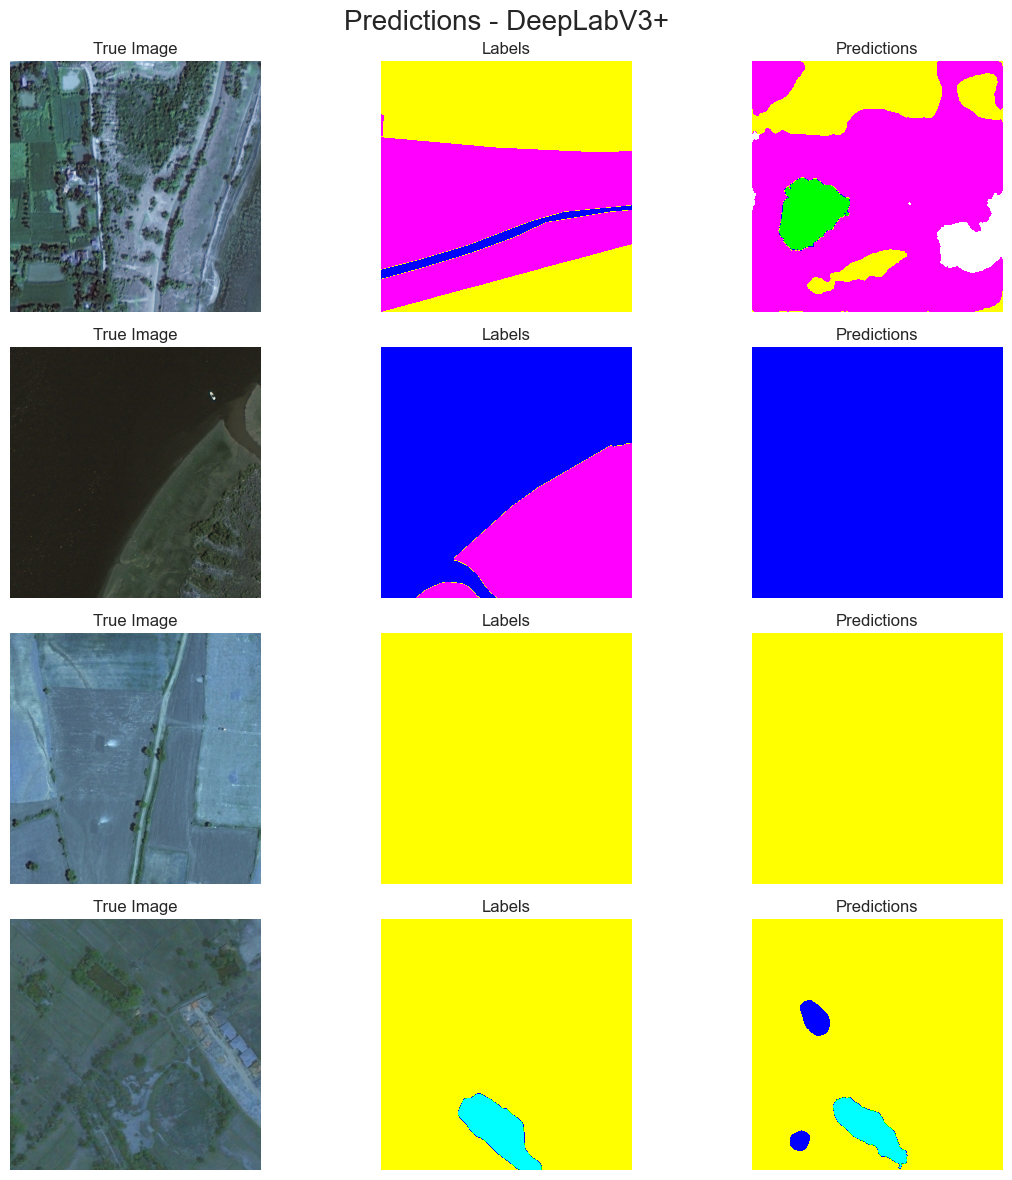

In [35]:
# indices = [957,961,1476,1578]
visualize_preds(model, test_set, title = "Predictions - DeepLabV3+",
                save_title = "DeepLabV3+", h = 12, w = 12)